In [1]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import ScalarFormatter
# from sklearn.linear_model import RANSACRegressor

from glob import glob
from dataclasses import dataclass

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from lib import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

## Load

In [2]:
data = load("250321-exp7")

/Users/matteov/Developer/lab3/05-milieux-granulaires/analyse/lib.py:29: UserWarning: loadtxt: input contained no data: "../data/250321-exp7/250321-exp7_step11.txt"
  freq, psd, chi_abs, chi_im = np.loadtxt(file, skiprows=1, delimiter='\t', unpack=True)


## Analysis

### Noise removal and filtering

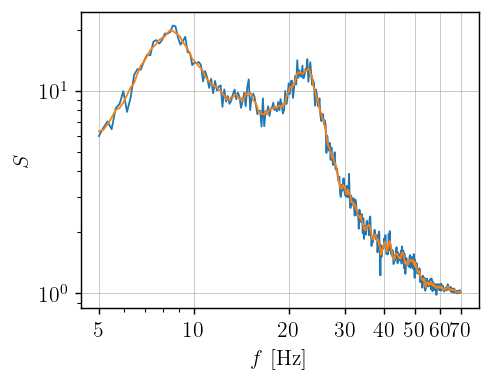

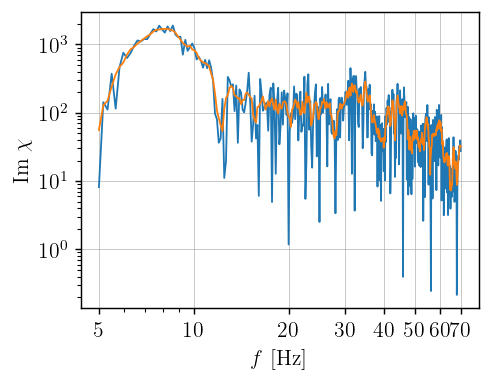

In [7]:
fig, ax = plt.subplots()
noise = data[-1].psd
step = data[2]

# Remove system noise from spectra
clean_psd = step.psd / noise
clean_chi_im = step.chi_im / noise

# Moving average filter
window_size = 5
averaged_psd = moving_average(clean_psd, window_size)
averaged_chi_im = moving_average(clean_chi_im, window_size)

# Plot results
plt.loglog(step.freqs, clean_psd)
plt.loglog(step.freqs, averaged_psd)

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xticks([5,10,20,30,40,50,60,70])
plt.xlabel("$f$ [Hz]")
plt.ylabel("$S$")
plt.show()


plt.loglog(step.freqs, clean_chi_im)
plt.loglog(step.freqs, averaged_chi_im)

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xticks([5,10,20,30,40,50,60,70])
plt.xlabel("$f$ [Hz]")
plt.ylabel("Im $\\chi$")
plt.show()


401
401


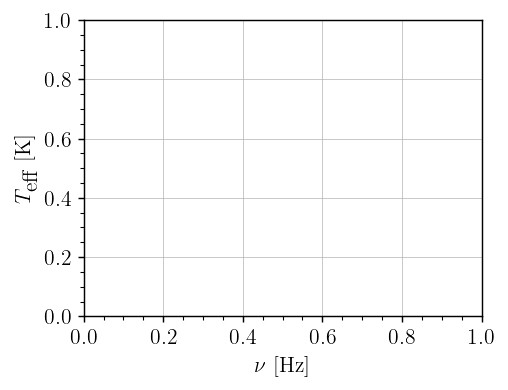

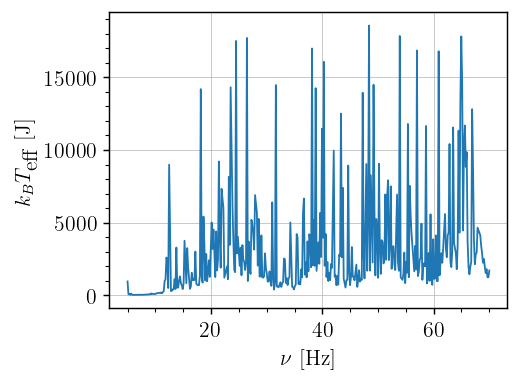

In [4]:

kB_Teff = (clean_psd * 2*np.pi*step.freqs) / (4 * step.chi_im)
Teff = kB_Teff/ BOLTZMANN_CONSTANT_JOULE

good_idx = np.abs(sc.stats.zscore(kB_Teff)) < 0.3

print(np.sum(kB_Teff > 0))
print(Teff.size)


ax.plot(step.freqs, Teff)
# plt.ylim(-1e25,1e25)
plt.xlabel(r"$\nu$ [Hz]")
plt.ylabel(r"$T_\textrm{eff}$ [K]")

plt.show()

plt.plot(step.freqs[good_idx], kB_Teff[good_idx])
plt.xlabel(r"$\nu$ [Hz]")
plt.ylabel(r"$k_B T_\textrm{eff}$ [J]")

plt.show()
